In [2]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from sklearn.metrics import roc_auc_score, roc_curve
import matplotlib.pyplot as plt

In [3]:
df = pd.read_csv('titanic.csv')
df.shape

(891, 15)

In [4]:
print(df.head(1).T.to_string())

                       0
survived               0
pclass                 3
sex                 male
age                 22.0
sibsp                  1
parch                  0
fare                7.25
embarked               S
class              Third
who                  man
adult_male          True
deck                 NaN
embark_town  Southampton
alive                 no
alone              False


In [ ]:
# Step 3: Calculate WoE and IV
def woe_iv(df, feature, target):
    grouped = df.groupby(feature, observed=False)[target].agg(["count", "sum"])
    grouped.columns = ["total", "bad"]
    grouped["good"] = grouped["total"] - grouped["bad"]
    dist_good = grouped["good"] / grouped["good"].sum()
    dist_bad = grouped["bad"] / grouped["bad"].sum()
    grouped["woe"] = np.log((dist_good + 1e-6) / (dist_bad + 1e-6))  # smoothing
    grouped["iv"] = (dist_good - dist_bad) * grouped["woe"]
    iv = grouped["iv"].sum()
    return grouped[["woe"]], iv, grouped


IV: 1.4863


,total,bad,good,woe,iv
who,,,,,
child,83,49,34,-0.838738,0.068226
man,537,88,449,1.156396,0.648207
woman,271,205,66,-1.606636,0.769895


In [10]:
col = 'who'
woe_table_who, iv, grouped = woe_iv(df, col, "survived")
print(f"{col} IV: {iv:.4f}")

col = 'class'
woe_table2_class, iv, grouped = woe_iv(df, col, "survived")
print(f"{col} IV: {iv:.4f}")

who IV: 1.4863
class IV: 0.5009


In [11]:
df = df.merge(woe_table_who, left_on="who", right_index=True)
df.rename(columns={"woe": "who_woe"}, inplace=True)

df = df.merge(woe_table2_class, left_on="class", right_index=True)
df.rename(columns={"woe": "class_woe"}, inplace=True)

print(df.head().to_string())

   survived  pclass     sex   age  sibsp  parch     fare embarked  class    who  adult_male deck  embark_town alive  alone   who_woe  class_woe
0         0       3    male  22.0      1      0   7.2500        S  Third    man        True  NaN  Southampton    no  False  1.156396   0.666481
1         1       1  female  38.0      1      0  71.2833        C  First  woman       False    C    Cherbourg   yes  False -1.606636  -1.003912
2         1       3  female  26.0      0      0   7.9250        S  Third  woman       False  NaN  Southampton   yes   True -1.606636   0.666481
3         1       1  female  35.0      1      0  53.1000        S  First  woman       False    C  Southampton   yes  False -1.606636  -1.003912
4         0       3    male  35.0      0      0   8.0500        S  Third    man        True  NaN  Southampton    no   True  1.156396   0.666481


In [12]:
# Step 5: Logistic regression
X = sm.add_constant(df[["who_woe", "class_woe"]])
logit_model = sm.Logit(df["survived"], X)
result = logit_model.fit(disp=0)
print(result.summary())

                           Logit Regression Results                           
Dep. Variable:               survived   No. Observations:                  891
Model:                          Logit   Df Residuals:                      888
Method:                           MLE   Df Model:                            2
Date:                Tue, 19 Aug 2025   Pseudo R-squ.:                  0.3301
Time:                        23:30:06   Log-Likelihood:                -397.48
converged:                       True   LL-Null:                       -593.33
Covariance Type:            nonrobust   LLR p-value:                 8.814e-86
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.4686      0.089     -5.279      0.000      -0.643      -0.295
who_woe       -1.0817      0.074    -14.683      0.000      -1.226      -0.937
class_woe     -1.2047      0.130     -9.237      0.0

Gini: 0.7024


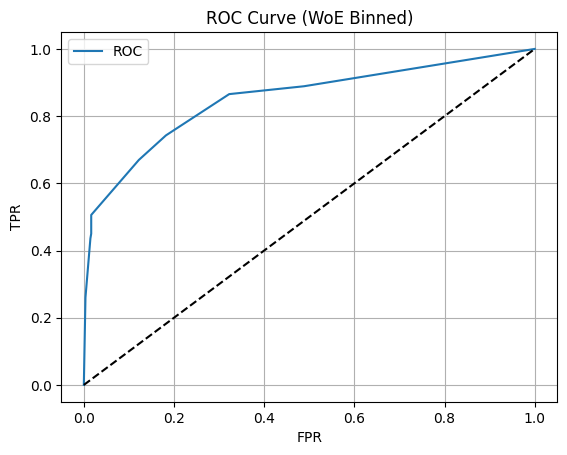

In [14]:
# Step 6: ROC + Gini
probs = result.predict(X)

auc = roc_auc_score(df["survived"], probs)
gini = 2 * auc - 1
print("Gini: {:.4f}".format(gini))

fpr, tpr, _ = roc_curve(df["survived"], probs)
plt.plot(fpr, tpr, label="ROC")
plt.plot([0, 1], [0, 1], "k--")
plt.title("ROC Curve (WoE Binned)")
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.legend()
plt.grid()
plt.show()